# Basic lightcurve

In [1]:
%matplotlib inline
from glob import glob

try:
    from astropy.io import pf
except:
    import pyfits as pf

import numpy as np
from datetime import datetime as dt
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
#import pandas as pd

#filedir='/media/jpdl/B838B30438B2C124/df_HATP44/'
filedir='/mnt/B838B30438B2C124/df_HATP44/'
file_list = glob(filedir+'*.fits') 
file_list.sort()

len(file_list)

1457

In [2]:
gband=[]
rband=[]
zband=[]

for i in file_list:
    hdr = pf.open(i)[0].header
    #if hdr['OBJECT']  == 'HAT-P-44':
    if hdr['FILTER'] == 'g':
        gband.append(i)
    elif hdr['FILTER'] == 'r':
        rband.append(i)
    elif hdr['FILTER'] == 'z_s':
        zband.append(i)
    else: #redundancy
        print(i)
        
print('{0}\n{1}\n{2}'.format(len(gband), len(rband), len(zband)))

376
704
377


## Test image

In [7]:
test_image = pf.open(gband[0])[0].data

## Crop image

In [8]:
import numpy as np

def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

In [9]:
centroid = (700, 305)
test_image_crop = get_crop(test_image, centroid, box_size=80)

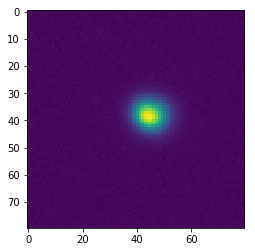

In [10]:
plt.imshow(test_image_crop)

## Compute Centroid 

In [11]:
from photutils.centroids import centroid_com as com

def get_centroid(image):
    '''
    Calculate the centroid of a 2D array as its “center of mass” determined from image moments.
    '''
    centroid = com(image)
    return centroid

In [12]:
centroid = get_centroid(test_image_crop)
centroid

array([ 39.85587354,  39.38727026])

## Do photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)

for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)

In [13]:
from photutils import CircularAperture
from photutils import aperture_photometry


def get_phot(image, centroid, r=10):
    fwhm = 8.0
    
    apertures = CircularAperture(centroid, r)
    phot_table = aperture_photometry(image, apertures)
    
    #xcenter = phot_table['xcenter']
    #ycenter = phot_table['ycenter']
    #centroid = (xcenter, ycenter)
    aperture_sum = float(phot_table['aperture_sum'])
    
    return aperture_sum #,centroid

In [14]:
aperture_sum = get_phot(test_image_crop, centroid)
aperture_sum

1693392.6533980244

## Masking

In [15]:
def cmask(image,centroid,aperture_radius):
    a,b = get_centroid(image)
    nx,ny = image.shape
    y,x = np.ogrid[-a:nx-a,-b:ny-b]
    mask = x*x + y*y <= aperture_radius**2
    
    add = sum(image[mask])
    background = np.median(image[~mask])
    
    return background

In [16]:
cmask(test_image_crop, centroid, aperture_radius=15)

2566.3691

In [20]:
centroid_init = (700, 305)
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []

for i in gband:
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    image_crop = get_crop(img, centroid_init, box_size)
    #compute centroid
    centroid = get_centroid(image_crop)
    centroids.append(centroid)
    
    xcenters.append(centroid[0])
    ycenters.append(centroid[1])
    
    #do photometry
    aperture_sum = get_phot(image_crop, centroid)
    aperture_sums.append(aperture_sum)

In [21]:
import pandas as pd

#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'aperture_sum'    : aperture_sums}

df_gband = pd.DataFrame(d, index = obs_time)

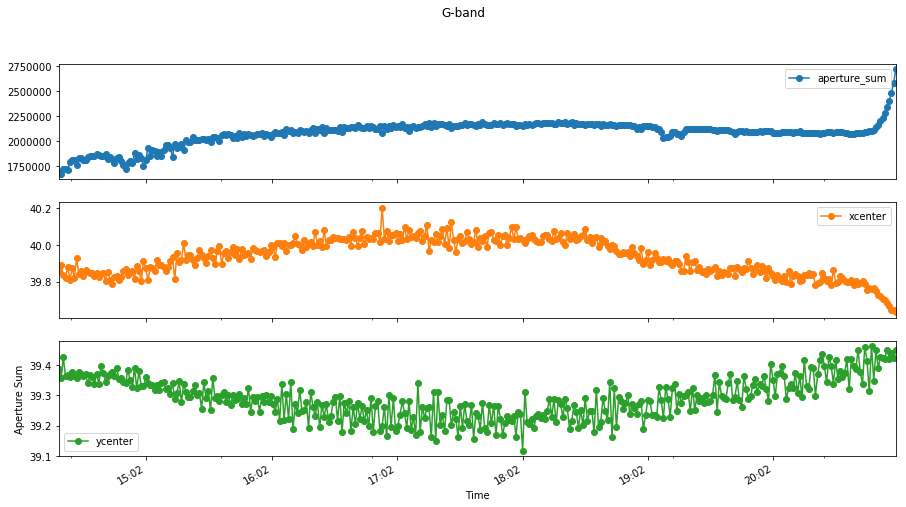

In [25]:
import matplotlib.dates as dates

axs = df_gband.plot(title='G-band', marker='o', subplots=True, figsize=(15,8))
axs.flat[2].xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
axs.flat[2].set_ylabel('Aperture Sum')
axs.flat[2].set_xlabel('Time')

In [24]:
centroid_init = (700, 305)
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []

for i in rband:
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    image_crop = get_crop(img, centroid_init, box_size)
    #compute centroid
    centroid = get_centroid(image_crop)
    centroids.append(centroid)
    
    xcenters.append(centroid[0])
    ycenters.append(centroid[1])
    
    #do photometry
    aperture_sum = get_phot(image_crop, centroid)
    aperture_sums.append(aperture_sum)
    
#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'aperture_sum'    : aperture_sums}

df_rband = pd.DataFrame(d, index = obs_time)

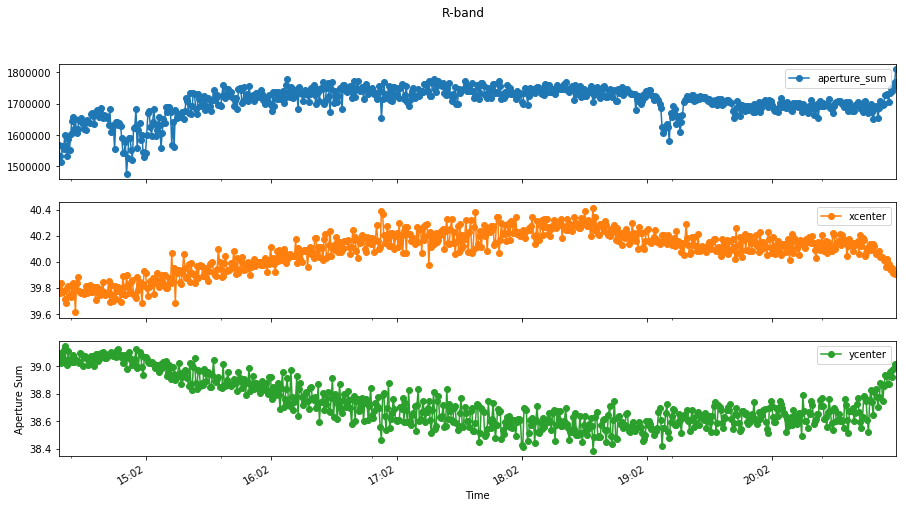

In [26]:
import matplotlib.dates as dates

axs = df_rband.plot(title='R-band', marker='o',subplots=True, figsize=(15,8))
axs.flat[2].xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
axs.flat[2].set_ylabel('Aperture Sum')
axs.flat[2].set_xlabel('Time')

In [27]:
centroid_init = (700, 305)
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []

for i in zband:
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    image_crop = get_crop(img, centroid_init, box_size)
    #compute centroid
    centroid = get_centroid(image_crop)
    centroids.append(centroid)
    
    xcenters.append(centroid[0])
    ycenters.append(centroid[1])
    
    #do photometry
    aperture_sum = get_phot(image_crop, centroid)
    aperture_sums.append(aperture_sum)
    
#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'aperture_sum'    : aperture_sums}

df_zband = pd.DataFrame(d, index = obs_time)

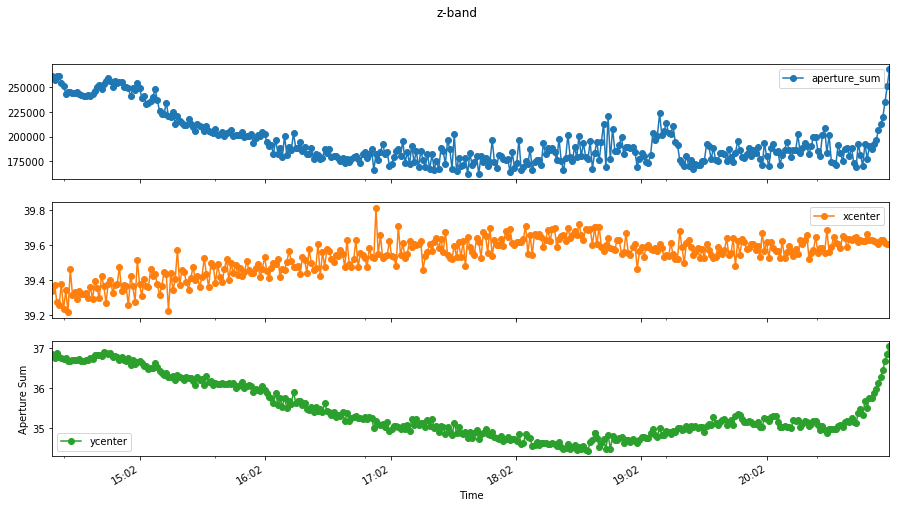

In [28]:
import matplotlib.dates as dates

axs = df_zband.plot(title='z-band', marker='o', subplots=True, figsize=(15,8))
axs.flat[2].xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
axs.flat[2].set_ylabel('Aperture Sum')
axs.flat[2].set_xlabel('Time')

In [29]:
df_rband.columns = ['aperture_sum2', 'xcenter2', 'ycenter2']
df_zband.columns = ['aperture_sum3', 'xcenter3', 'ycenter3']
df_all = df_gband.append([df_rband, df_zband])

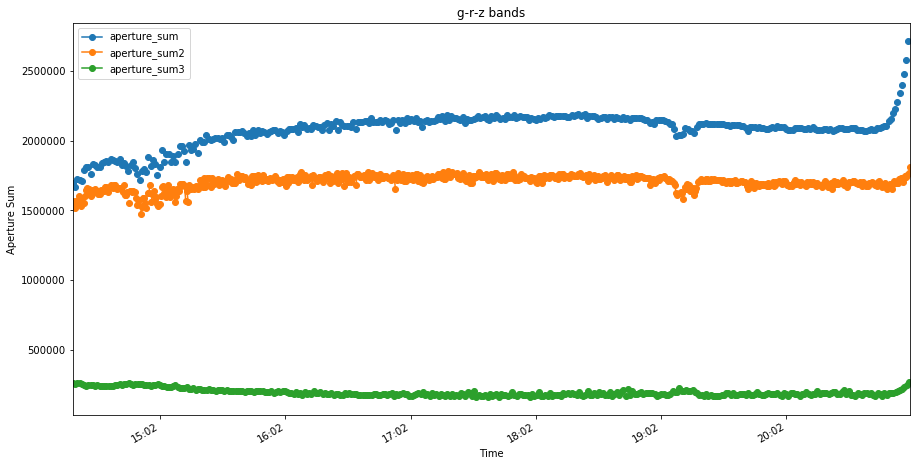

In [30]:
import matplotlib.dates as dates

ax = df_all[['aperture_sum','aperture_sum2','aperture_sum3']].plot(title='g-r-z bands', marker='o', figsize=(15,8))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
ax.set_ylabel('Aperture Sum')
ax.set_xlabel('Time')

In [41]:
df_all.rename(columns={'aperture_sum':'flux_g', 'aperture_sum2':'flux_r', 'aperture_sum3':'flux_z'}, inplace=True)

In [42]:
df_all.head()

,flux_g,flux_r,flux_z,xcenter,xcenter2,xcenter3,ycenter,ycenter2,ycenter3
2017-02-15 14:18:14.529240,1.693393e+06,NaN,NaN,39.855874,NaN,NaN,39.387270,NaN,NaN
2017-02-15 14:19:18.961023,1.670733e+06,NaN,NaN,39.888606,NaN,NaN,39.357057,NaN,NaN
2017-02-15 14:20:23.220731,1.724041e+06,NaN,NaN,39.835488,NaN,NaN,39.424931,NaN,NaN
2017-02-15 14:21:26.308946,1.718451e+06,NaN,NaN,39.816575,NaN,NaN,39.362446,NaN,NaN
2017-02-15 14:22:30.000543,1.712989e+06,NaN,NaN,39.880492,NaN,NaN,39.366442,NaN,NaN


## Saving to csv.gz

In [43]:
df_all.to_csv('hatp44_trail1.csv.gz')

## Manual point retrieval per band (g-r-z) and point source (3)

loop over `idx` and `band` for centroid/point source and g

In [44]:
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []
sum_per_band = {}

bands = [gband,rband,zband]
band_name = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]

idx=0
band=0

for i in bands[band]:
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    image_crop = get_crop(img, centroids[idx], box_size)
    #compute centroid
    centroid = get_centroid(image_crop)
    centroids.append(centroid)

    xcenters.append(centroid[0])
    ycenters.append(centroid[1])

    #do photometry
    aperture_sum = get_phot(image_crop, centroid)
    aperture_sums.append(aperture_sum)
    
#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'flux'+str(band_name[idx])    : aperture_sums}

In [ ]:
#change name (df_gband, df_rband, df_zband) per run 
df_gband = pd.DataFrame(d, index = obs_time)

After running 1 set above, merge 3 df below

In [ ]:
DF_all = df_gband_star1.append([df_rband_star1, df_zband_star1])

In [ ]:
#change name (_star1, _star2, _star3) per run
DF_all.to_csv('hatp44_star1.csv.gz')